# Contents
* [Introduction](#Introduction)
* [Imports and configuration](#Imports-and-configuration)
* [Data loading](#Data-loading)
* [Setup](#Setup)
* [Score models](#Score-models)
* [Results](#Results)
* [Discussion](#Discussion)

# Introduction

The following classifiers were previously cross validated with untuned hyperparameters:
* LinearDiscrimantAnalysis
* LogisticRegression
* RidgeClassifier
* SGDClassifier
* SVC

This notebook introduces average precision and Jaccard scores as additional metrics for model selection. 

# Imports and configuration

In [1]:
from time import time

notebook_begin_time = time()

# set random seeds

from os import environ
from random import seed as random_seed
from numpy.random import seed as np_seed
from tensorflow.random import set_seed


def reset_seeds(seed: int) -> None:
    """Utility function for resetting random seeds"""
    environ["PYTHONHASHSEED"] = str(seed)
    random_seed(seed)
    np_seed(seed)
    set_seed(seed)


reset_seeds(SEED := 2021)
del environ
del random_seed
del np_seed
del set_seed
del reset_seeds

In [2]:
# extensions
%load_ext autotime
%load_ext lab_black
%load_ext nb_black

In [3]:
# core
import numpy as np
import pandas as pd

# utility
from collections import namedtuple
from gc import collect as gc_collect
from os.path import exists
from tqdm.notebook import tqdm

# typing
from typing import Dict, List, Union

# faster pandas & sklearn
import swifter
from sklearnex import patch_sklearn

patch_sklearn()
del patch_sklearn

# metrics
from imblearn.metrics import geometric_mean_score
from sklearn.metrics import (
    balanced_accuracy_score,
    f1_score,
    jaccard_score,
    roc_auc_score,
)

# visualization
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_context("notebook")
sns.set_style("whitegrid")
%matplotlib inline

# display outputs w/o print calls
from IPython.core.interactiveshell import InteractiveShell

InteractiveShell.ast_node_interactivity = "all"
del InteractiveShell

# hide warnings
import warnings

# warnings.filterwarnings("ignore")
del warnings

Intel(R) Extension for Scikit-learn* enabled (https://github.com/intel/scikit-learn-intelex)


time: 4.64 s


In [4]:
# Location of cross validation data
FRILL_FEATHERS_FOLDER = "../10.0-mic-prepare_train-test_splits_on_full_data"

# Location of cross validated prediction results
RESULTS_FOLDER = "."

# Location where this notebook will output
DATA_OUT_FOLDER = "."

_ = gc_collect()

time: 107 ms


# Load data

Previously recorded results are loaded in this section.

In [5]:
results_df = pd.read_csv(f"{RESULTS_FOLDER}/untuned_full_results_CV5.csv").drop(
    columns="Unnamed: 0"
)
results_df.case = results_df.case.astype("category")
results_df.head()
results_df.info()

,model_name,case,geometric_mean,f1,balanced_accuracy,fit_time,predict_time
0,SVC,negative,0.666719,0.679755,0.672735,317.956529,51.399344
1,Ridge,negative,0.645930,0.654431,0.648998,4.753259,0.037116
2,LDA,negative,0.643996,0.653322,0.647329,34.396286,0.045120
3,LogReg,negative,0.642722,0.651208,0.645692,10.175857,0.046320
4,SGD,negative,0.640984,0.650131,0.645135,19.638570,0.038648


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 54 entries, 0 to 53
Data columns (total 7 columns):
 #   Column             Non-Null Count  Dtype   
---  ------             --------------  -----   
 0   model_name         54 non-null     object  
 1   case               54 non-null     category
 2   geometric_mean     54 non-null     float64 
 3   f1                 54 non-null     float64 
 4   balanced_accuracy  54 non-null     float64 
 5   fit_time           54 non-null     float64 
 6   predict_time       54 non-null     float64 
dtypes: category(1), float64(5), object(1)
memory usage: 2.9+ KB
time: 44.3 ms


In [6]:
predictions_df = pd.read_feather(
    f"{RESULTS_FOLDER}/untuned_performant_models_predictions_CV5.feather"
)
predictions_df.head()
predictions_df.info()

,model,case,fold,y_pred
0,Dummy,negative,0,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
1,Dummy,negative,1,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
2,Dummy,negative,2,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
3,Dummy,negative,3,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."
4,Dummy,negative,4,"[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, ..."


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 270 entries, 0 to 269
Data columns (total 4 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   model   270 non-null    object  
 1   case    270 non-null    category
 2   fold    270 non-null    uint8   
 3   y_pred  270 non-null    object  
dtypes: category(1), object(2), uint8(1)
memory usage: 5.1+ KB
time: 59.4 ms


# Setup

In this section, we define some structures to keep track of models and scores.

In [7]:
METRICS = (
    "balanced_accuracy",
    "f1",
    "geometric_mean",
    "jaccard",
    "roc_auc",
    "fit_time",
    "predict_time",
)

# to be cast to pd.DataFrame
make_results = lambda: {key: [] for key in {"model_name", "case", *METRICS}}
results_ = make_results()

AvgScores = namedtuple("AvgScores", METRICS)


def store_result(
    where: Dict[str, List],
    case: str,
    model_name: str,
    avg_scores: AvgScores,
) -> None:
    "Appends a model's scores and fit/predict times to the results dict."
    for attribute, value in {
        "model_name": model_name,
        "case": case,
        **avg_scores._asdict(),
    }.items():
        where[attribute].append(value)


ALL_CASES = {"negative", "neutral", "ternary", "ternary_negneu"}

_ = gc_collect()

time: 103 ms


# Score models

This time, we use the `adjusted` parameter for balanced_accuracy_score, which ascribes a 0 score to random guessing.

In [8]:
def prep_y_pred(label: Union[int, bool], case: str) -> List:
    """Prepares labels for AUROC scoring"""
    if "ternary" in case:
        _ = [0, 0, 0]
        _[int(label)] = 1
        return np.asarray(_, dtype=np.int8)
    else:
        return label


for case in ALL_CASES:
    pred_df = pd.DataFrame(predictions_df).query(f"case == '{case}'")
    for model in tqdm(np.unique(pred_df.model)):
        balanced_accuracy, f1, jaccard, geometric_mean, roc_auc = (
            [],
            [],
            [],
            [],
            [],
        )
        fold_num = 0
        while True:
            if not exists(
                ytrue_path := f"{FRILL_FEATHERS_FOLDER}/cv_{fold_num}/y_test_{case[:3]}.feather"
            ):
                break

            # score
            score_params = {
                "y_true": np.squeeze(pd.read_feather(ytrue_path).values),
                "y_pred": pred_df.query(
                    f"fold == {fold_num} & model == '{model}'"
                ).y_pred.item(),
            }
            balanced_accuracy.append(
                balanced_accuracy_score(**score_params, adjusted=True)
            )
            f1.append(f1_score(**score_params, average="weighted"))
            geometric_mean.append(geometric_mean_score(**score_params))
            jaccard.append(jaccard_score(**score_params, average="weighted"))
            roc_auc.append(
                roc_auc_score(
                    y_true=score_params["y_true"].astype(np.int8),
                    y_score=np.stack(
                        pd.Series(score_params["y_pred"]).swifter.apply(
                            prep_y_pred, case=case
                        )
                    ),
                    average="weighted",
                    multi_class="ovo",
                )
            )
            del score_params
            _ = gc_collect()
            fold_num += 1
        del fold_num

        times = results_df.query(f"case == '{case}' & model_name == '{model}'")[
            ["fit_time", "predict_time"]
        ]
        store_result(
            where=results_,
            case=case,
            model_name=model,
            avg_scores=AvgScores(
                np.mean(balanced_accuracy),
                np.mean(f1),
                np.mean(geometric_mean),
                np.mean(jaccard),
                np.mean(roc_auc),
                times.fit_time.item(),
                times.predict_time.item(),
            ),
        )
        del balanced_accuracy
        del f1
        del geometric_mean
        del jaccard
        del times
        _ = gc_collect()

        print(f"stored scores for {model}")
del pred_df
_ = gc_collect()

  0%|          | 0/6 [00:00<?, ?it/s]

stored scores for Dummy
stored scores for LDA
stored scores for LogReg
stored scores for Ridge
stored scores for SGD
stored scores for SVC


  0%|          | 0/36 [00:00<?, ?it/s]

Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 154517.59it/s]


stored scores for Dummy+Dummy


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 137526.89it/s]


stored scores for Dummy+LDA


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 246522.02it/s]


stored scores for Dummy+LogReg


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 211479.88it/s]


stored scores for Dummy+Ridge


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 234943.33it/s]


stored scores for Dummy+SGD


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 179699.83it/s]


stored scores for Dummy+SVC


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 141302.48it/s]


stored scores for LDA+Dummy


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 211605.73it/s]


stored scores for LDA+LDA


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 264354.68it/s]


stored scores for LDA+LogReg


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 166469.56it/s]


stored scores for LDA+Ridge


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 211636.73it/s]


stored scores for LDA+SGD


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 264375.85it/s]


stored scores for LDA+SVC


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 264521.08it/s]


stored scores for LogReg+Dummy


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 211619.93it/s]


stored scores for LogReg+LDA


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 211515.36it/s]


stored scores for LogReg+LogReg


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 211666.44it/s]


stored scores for LogReg+Ridge


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 211721.38it/s]


stored scores for LogReg+SGD


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 211605.73it/s]


stored scores for LogReg+SVC


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 264681.63it/s]


stored scores for Ridge+Dummy


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 211477.94it/s]


stored scores for Ridge+LDA


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 264540.26it/s]


stored scores for Ridge+LogReg


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 211619.29it/s]


stored scores for Ridge+Ridge


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 211517.94it/s]


stored scores for Ridge+SGD


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 211611.54it/s]


stored scores for Ridge+SVC


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 211576.02it/s]


stored scores for SGD+Dummy


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 211523.75it/s]


stored scores for SGD+LDA


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 211614.12it/s]


stored scores for SGD+LogReg


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 211503.74it/s]


stored scores for SGD+Ridge


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 264526.13it/s]


stored scores for SGD+SGD


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 211616.06it/s]


stored scores for SGD+SVC


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 211641.25it/s]


stored scores for SVC+Dummy


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 264454.50it/s]


stored scores for SVC+LDA


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 211577.32it/s]


stored scores for SVC+LogReg


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 211618.00it/s]


stored scores for SVC+Ridge


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 176339.09it/s]


stored scores for SVC+SGD


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 211725.90it/s]


stored scores for SVC+SVC


  0%|          | 0/6 [00:00<?, ?it/s]

stored scores for Dummy
stored scores for LDA
stored scores for LogReg
stored scores for Ridge
stored scores for SGD
stored scores for SVC


  0%|          | 0/6 [00:00<?, ?it/s]

Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 141307.37it/s]


stored scores for Dummy


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 206704.41it/s]


stored scores for LDA


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 174025.37it/s]


stored scores for LogReg


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 176410.87it/s]


stored scores for Ridge


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 222731.21it/s]


stored scores for SGD


Pandas Apply: 100%|██████████| 16532/16532 [00:00<00:00, 211520.52it/s]


stored scores for SVC
time: 1min 13s


Let's peek at the results.

In [9]:
results_df = (
    pd.DataFrame(results_)
    .sort_values(by=["model_name"], ascending=True)
    .sort_values(by=["fit_time", "predict_time"], ascending=True)
    .sort_values(by=["geometric_mean", "f1", "balanced_accuracy"], ascending=False)
    .sort_values(by=["case"], ascending=True)
    .reset_index(drop=True)
)[
    [  # selection order
        "model_name",
        "case",
        "balanced_accuracy",
        "f1",
        "geometric_mean",
        "jaccard",
        "roc_auc",
        "fit_time",
        "predict_time",
    ]
]
results_df.loc[:, "case"] = results_df.loc[:, "case"].astype("category")
results_df

,model_name,case,balanced_accuracy,f1,geometric_mean,jaccard,roc_auc,fit_time,predict_time
0,SVC,negative,0.345470,0.679755,0.666719,0.517421,0.672735,317.956529,51.399344
1,Ridge,negative,0.297996,0.654431,0.645930,0.488196,0.648998,4.753259,0.037116
2,LDA,negative,0.294658,0.653322,0.643996,0.487098,0.647329,34.396286,0.045120
3,LogReg,negative,0.291385,0.651208,0.642722,0.484648,0.645692,10.175857,0.046320
4,SGD,negative,0.290271,0.650131,0.640984,0.483685,0.645135,19.638570,0.038648
5,Dummy,negative,0.000000,0.375599,0.000000,0.289627,0.500000,0.003400,0.000800
6,Ridge,neutral,0.482940,0.768287,0.739624,0.635006,0.741470,7.696320,0.038642
7,SGD,neutral,0.480516,0.761309,0.739279,0.625193,0.740258,18.749660,0.043031
8,LDA,neutral,0.481060,0.767020,0.738908,0.633258,0.740530,50.441713,0.036673
9,LogReg,neutral,0.471352,0.770639,0.733144,0.638633,0.735676,15.453209,0.044446


time: 47 ms


# Results

In this section, we create several visualizations to display the results.

Note that the charts depicting fit and predict times do not account for the dimensionality reduction step.

In [10]:
METRIC_NAMES = {
    "average_precision": "Average Precision",
    "balanced_accuracy": "Balanced Accuracy",
    "f1": "F1 Score",
    "fit_time": "Fit Time",
    "jaccard": "Jaccard Similarity",
    "geometric_mean": "Geometric Mean",
    "roc_auc": "Area Under ROC Curve",
    "predict_time": "Predict Time",
}

_ = gc_collect()

time: 115 ms


In [11]:
def plot_binary_metric(metric: str, results_df: pd.DataFrame) -> None:
    """Draw a barplot by binary classifier."""
    time_metric = "time" in metric
    results_df = results_df.sort_values(by=metric, ascending=time_metric)
    if time_metric:
        # When plotting fit/predict times, the dummy classifier is omitted since it is always the fastest.
        results_df = results_df.loc[~results_df.model_name.str.contains("Dummy")]

    g = sns.catplot(
        x="model_name",
        y=metric,
        hue="case",
        data=results_df,
        hue_order=["neutral", "negative"],
        seed=SEED,
        kind="bar",
        palette="colorblind",
        alpha=0.65,
    )
    g.fig.set_figwidth(16)
    g.despine(**dict.fromkeys(("left", "top", "right"), True))
    g.set_axis_labels(x_var="", y_var="")
    sns.move_legend(
        g,
        "lower center",
        bbox_to_anchor=(0.5, 0.85),
        ncol=2,
        title=None,
    )

    if not time_metric:
        plt.ylim(0, 1)
    plt.setp(plt.gca().patches, linewidth=0)

    plt.suptitle(
        f"{METRIC_NAMES[metric]}{' (s)' if time_metric else ''}", fontweight="bold"
    )
    plt.tight_layout()
    plt.show()


_ = gc_collect()

time: 119 ms


  0%|          | 0/7 [00:00<?, ?it/s]

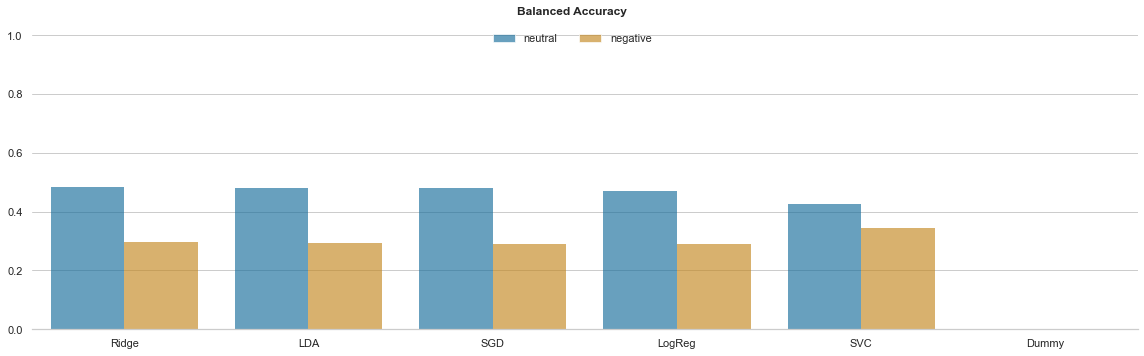

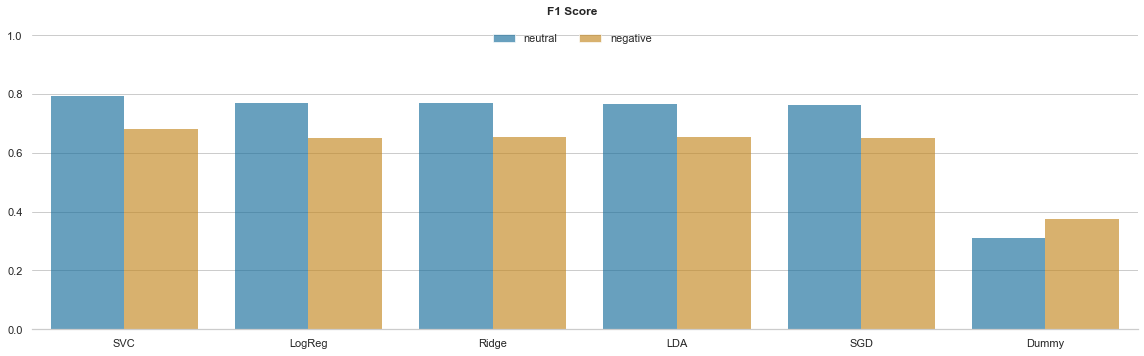

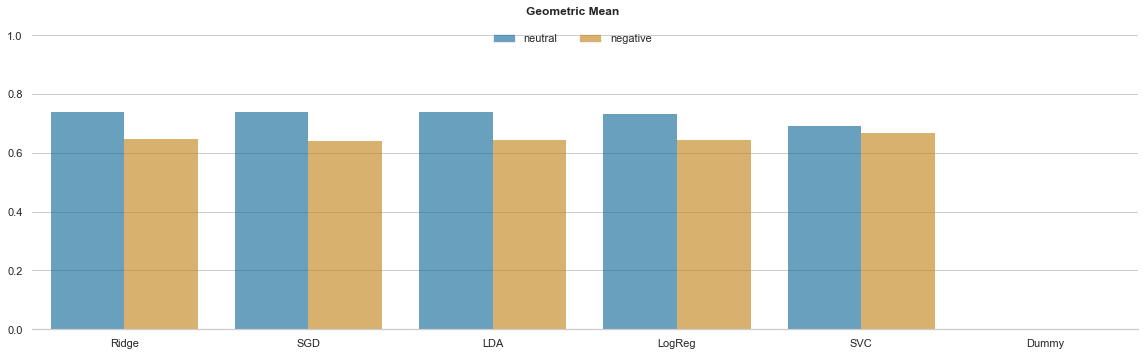

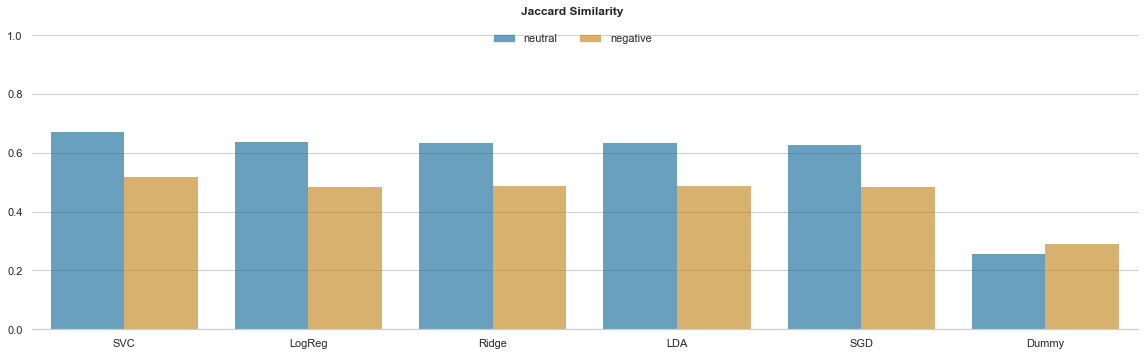

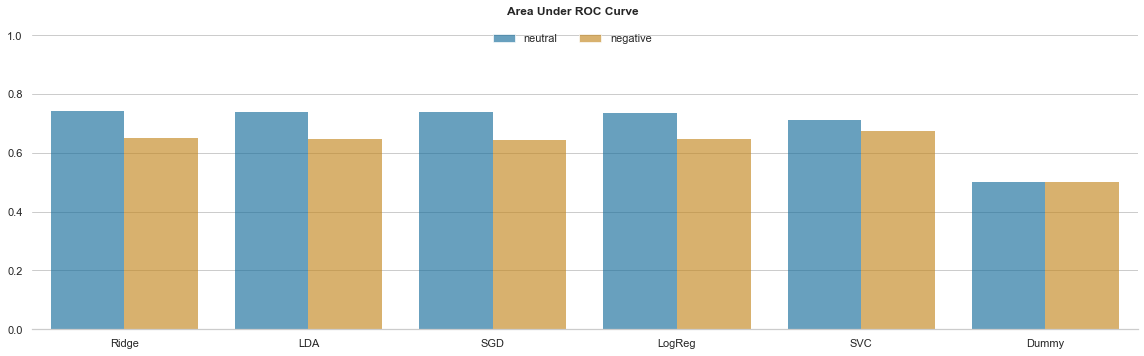

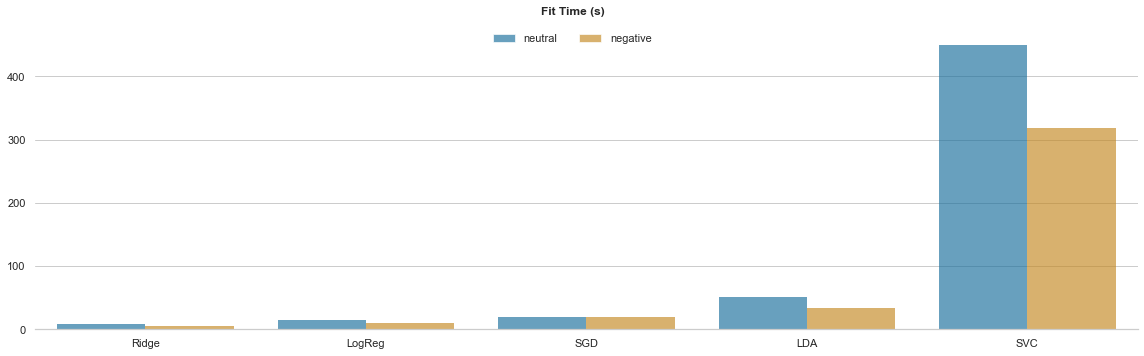

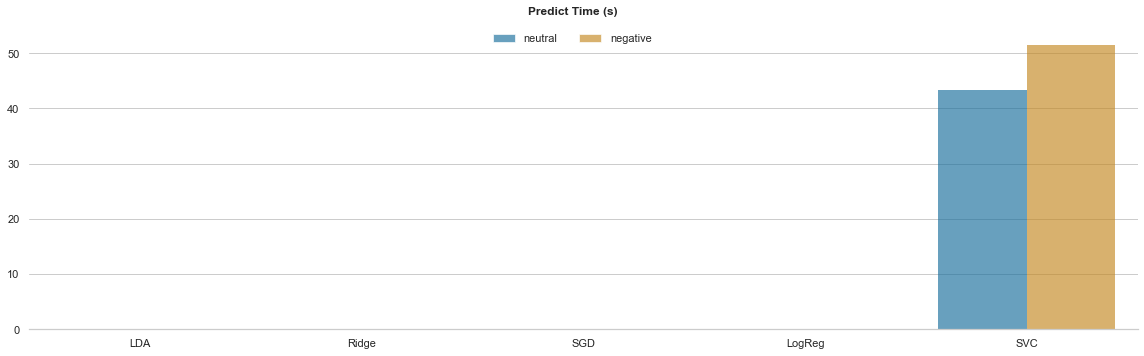

time: 3.32 s


In [12]:
for metric in tqdm(METRICS):
    plot_binary_metric(metric, results_df.loc[~results_df.case.str.contains("ternary")])

In [13]:
def plot_ternary_metric(metric: str, results_df: pd.DataFrame) -> None:
    """Draw a barplot by ternary classifier."""
    time_metric = "time" in metric
    results_df = results_df.sort_values(by=metric, ascending=time_metric)

    if time_metric:
        # When plotting fit/predict times, the pure dummy classifiers are omitted since it is always the fastest.
        results_df = results_df.loc[
            ~results_df.model_name.isin(("Dummy", "Dummy+Dummy"))
        ]

    g = sns.catplot(
        x=metric,
        y="model_name",
        data=results_df,
        seed=SEED,
        kind="bar",
        palette="colorblind",
        alpha=0.65,
    )
    g.fig.set_figwidth(10)
    g.fig.set_figheight(15)
    g.despine(**dict.fromkeys(("bottom", "left", "top", "right"), True))

    ax = plt.gca()
    ax.tick_params(axis="x", labelbottom=True, labeltop=True)
    plt.setp(ax.patches, linewidth=0)

    if not time_metric:
        plt.xlim(0, 1)
    plt.xlabel("")
    plt.ylabel("")

    plt.suptitle(
        f"{METRIC_NAMES[metric]}{' (s)' if time_metric else ''}", y=1, fontweight="bold"
    )
    plt.tight_layout()
    plt.show()


_ = gc_collect()

time: 167 ms


  0%|          | 0/7 [00:00<?, ?it/s]

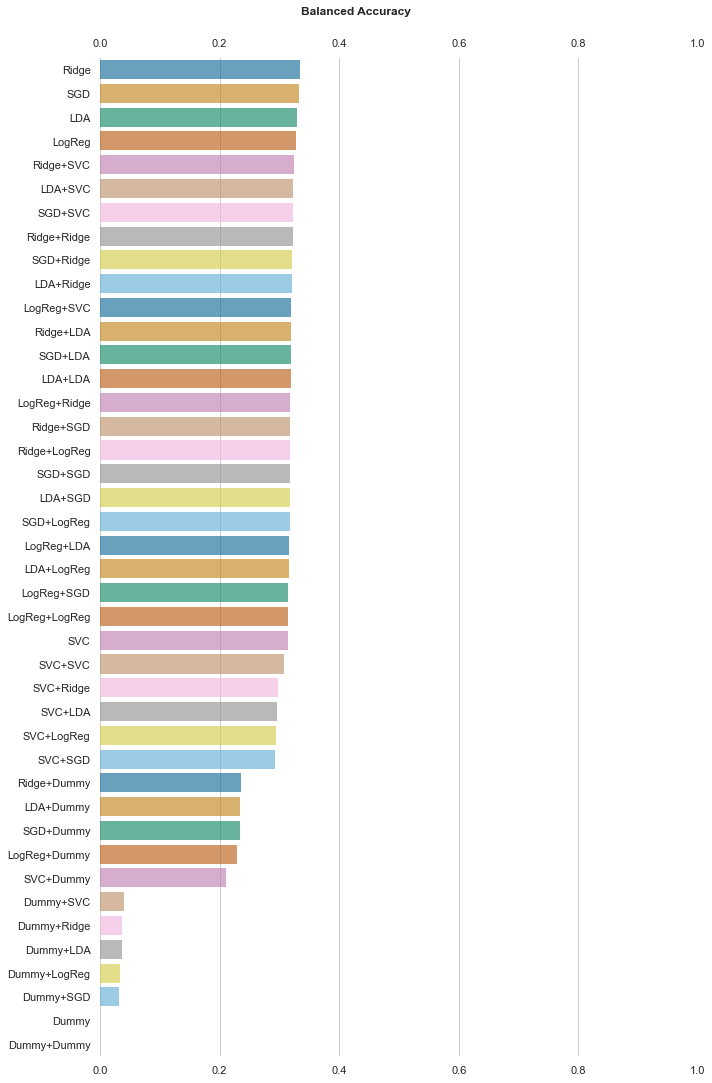

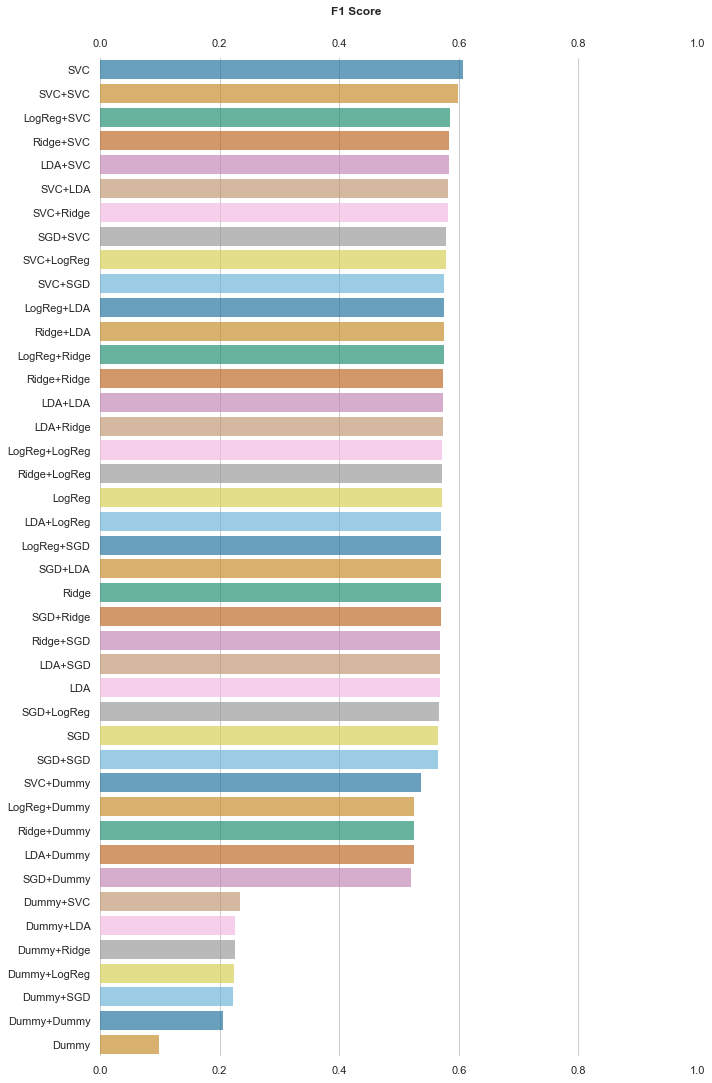

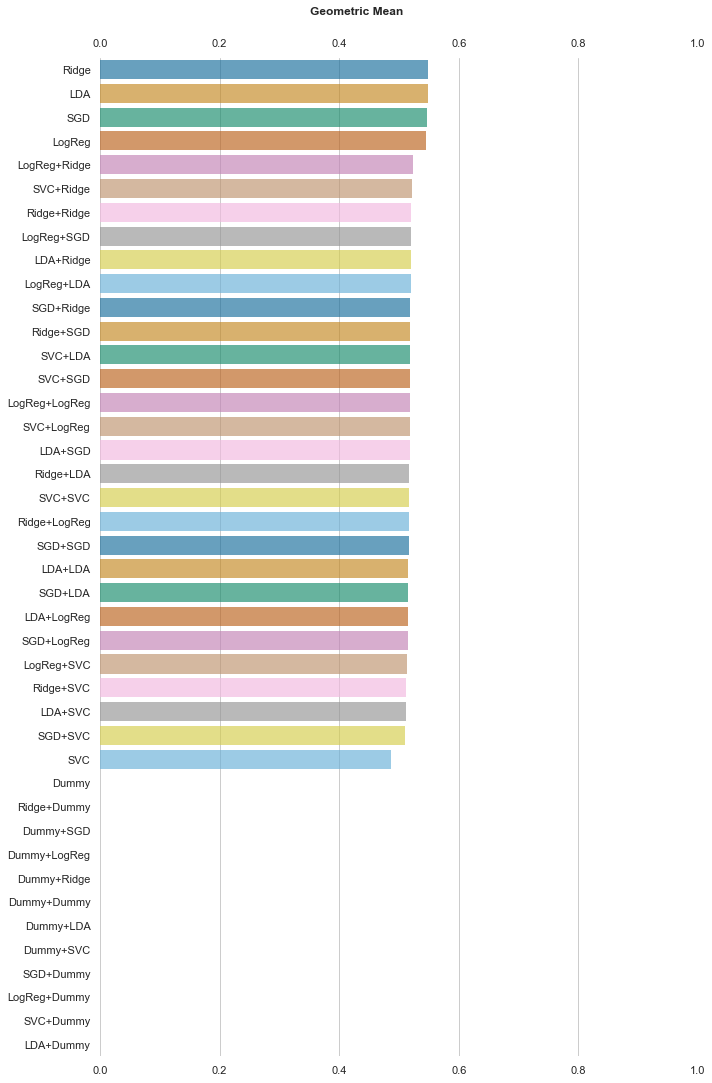

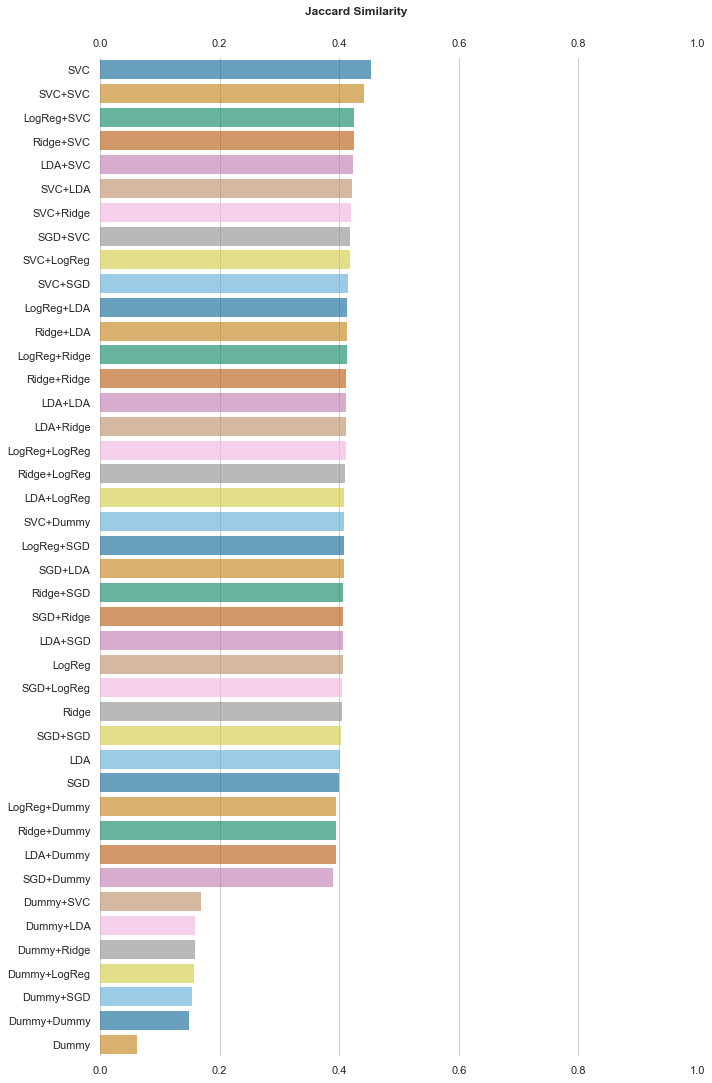

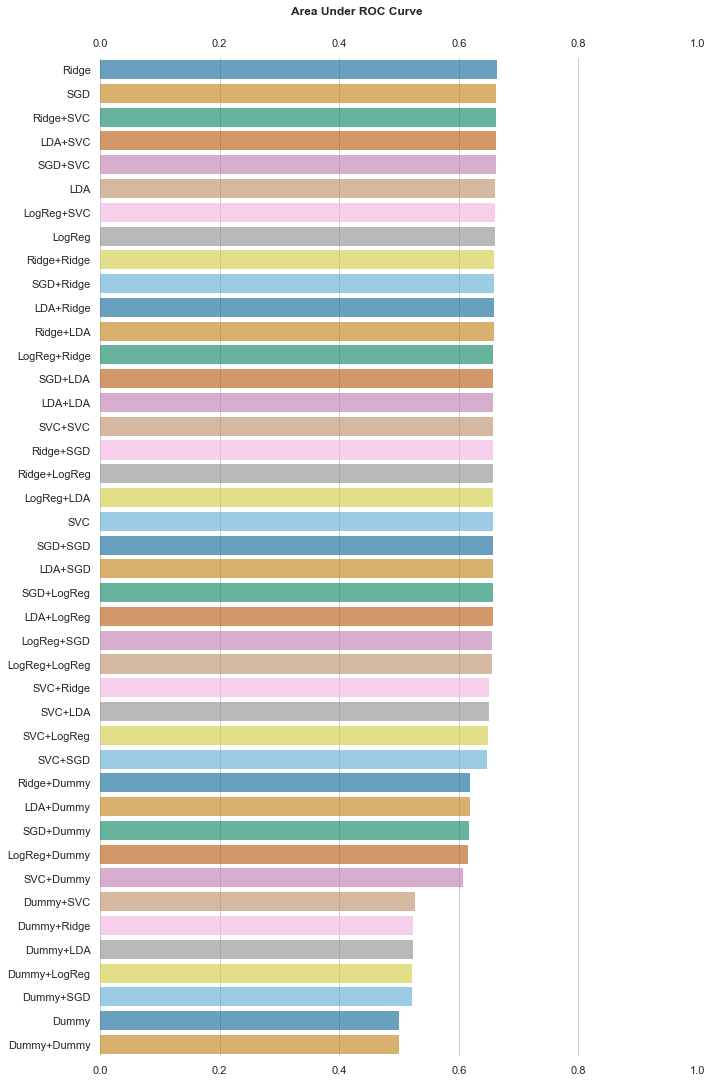

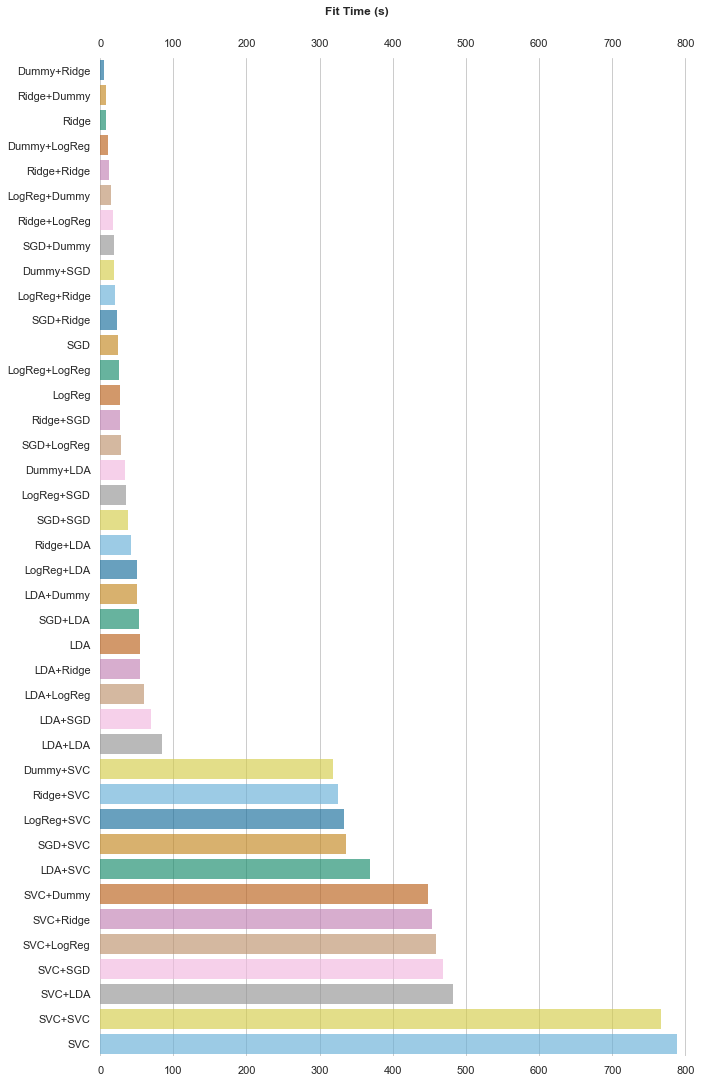

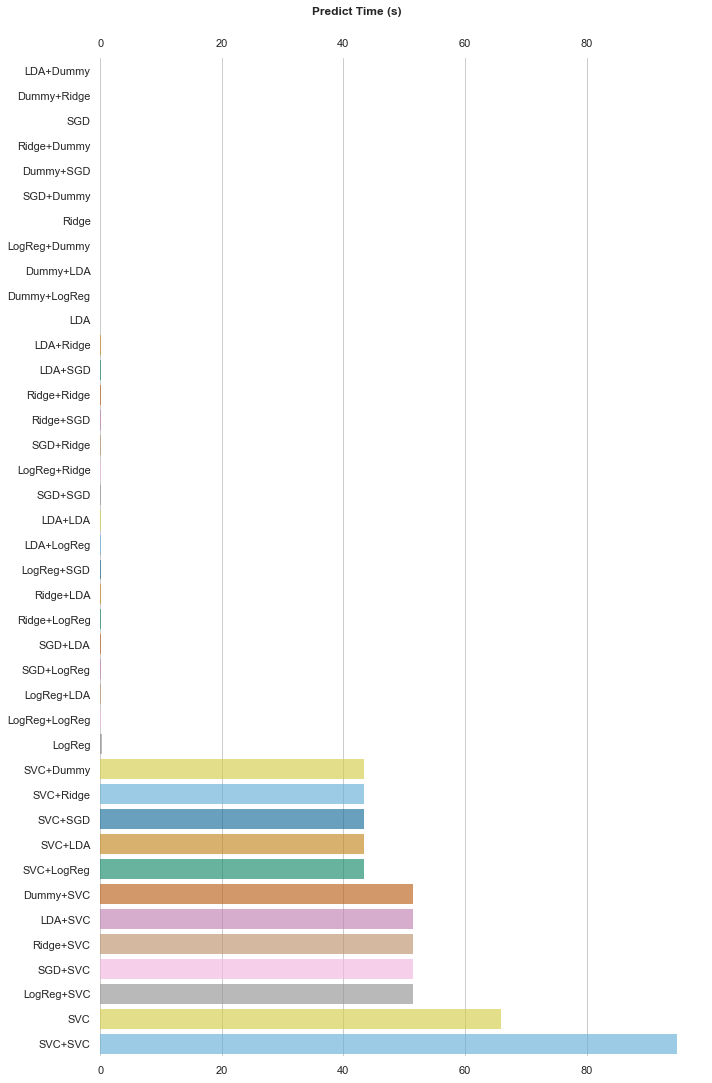

time: 6.77 s


In [14]:
for metric in tqdm(METRICS):
    plot_ternary_metric(metric, results_df.loc[results_df.case.str.contains("ternary")])

In [15]:
# save table of results
results_df.to_csv(f"{DATA_OUT_FOLDER}/untuned_full_results_CV5+metrics.csv")

time: 15.6 ms


# Discussion

The binary plots reveal that performance is better for neutral/non-neutral classification than for negative/non-negative classification.

SVC is particularly good at negative/non-negative classification by all scores. By F1 score and Jaccard similarity, it is also the most performant neutral/non-neutral classifier; this is true in the ternary cases as well. However, it is by far the slowest algorithm examined in both training and prediction.

The single ternary SVC was actually slower to train than the two-tiered SVC. This is the only two-stage estimator that was faster to fit than any one of its base estimators.

The ternary plots reveal Ridge, SGD, LDA, and LogReg as the most performant base classifiers by balanced accuracy, geometric mean, and AUROC while SVC wins by F1 score and Jaccard similarity (as noted).

In terms of balanced accuracy and geometric mean, no two-tiered estimator outperformed the respective single base estimators with the exception of SVC. For balanced accuracy, SVC works better when used solely as the negative/non-negative component. For geometric mean, SVC works better when used solely as the neutral/non-neutral component.

With the exception of SVC, the two-stage approach boosted F1 and Jaccard similarity scores the most. The rankings of the models by F1 and Jaccard similarity scores are rather similar.

In terms of AUROC, Ridge and SGD take first and second place. The two-tiered approach may have improved performance, but it is difficult to tell because all the top scores are so close.

Balanced accuracy and geometric mean are the metrics that reward dummy classification the least. Focusing on these two scores brings Ridge, SGD, LDA, and LogReg to the forefront of candidates. SVC is promising as a binary classifier, but it is slow enough to consider omitting from further consideration.

In [16]:
print(f"Time elapsed since notebook_begin_time: {time() - notebook_begin_time} s")
_ = gc_collect()

Time elapsed since notebook_begin_time: 96.47452092170715 s
time: 141 ms


[^top](#Contents)